In [1]:
# Investment Strategy Comparison Notebook

# --------------------------------------------
# 1. Imports and Configuration
# --------------------------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import size
from pyspark.ml.fpm import FPGrowth
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import re
import numba
import warnings
warnings.filterwarnings("ignore")

/Users/nickantoine/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# --------------------------------------------
# 2. Data Loading and Preparation
# --------------------------------------------
tickers = [
    "NVDA", "AMD", "INTC", "ASML", "MU", "TXN", "AVGO", "QCOM", "KLAC", "ON", "NXPI",
    "AAPL", "GOOG", "META", "IBM", "ORCL", "CRM", "ADBE",
    "SNOW", "PLTR", "CRWD", "DDOG", "MDB", "NET",
    "^VIX", "^TNX", "^IRX", "^FVX", "^TYX",
    "TLT", "IEF", "SHY", "BND", "LQD", "HYG", "AGG",
    "TGT", "COST", "BBY",
    "MSTR", "COIN", "RIOT", "MARA",
    "BABA", "JD", "PDD", "BIDU", "TCEHY", "UMC",
    "GC=F", "SI=F", "HG=F", "PL=F", "CL=F", "NG=F",
    "UPS", "FDX", "XPO",
    "TSLA", "GM", "F", "NIO", "LI", "XPEV",
    "LMT", "NOC", "RTX", "BA", "GD"
]
train_start_date = "2021-06-01"
test_start_date = "2023-05-01"
test_end_date = "2025-04-01"

train_dfs, test_dfs = [], []
for t in tickers:
    df = yf.Ticker(t).history(start=train_start_date, end=test_start_date)
    df["Ticker"] = t
    train_dfs.append(df)
    df = yf.Ticker(t).history(start=test_start_date, end=test_end_date)
    df["Ticker"] = t
    test_dfs.append(df)

train_df = pd.concat(train_dfs).reset_index()
test_df = pd.concat(test_dfs).reset_index()

for df in [train_df, test_df]:
    df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_convert(None).dt.date
    df['Up'] = (df['Close'] > df['Open']).astype(int)
    df['Down'] = (df['Close'] < df['Open']).astype(int)

def format_result(df):
    up = df.pivot(index='Date', columns='Ticker', values='Up')
    down = df.pivot(index='Date', columns='Ticker', values='Down')
    up.columns = [f"{c}_Up" for c in up.columns]
    down.columns = [f"{c}_Down" for c in down.columns]
    return pd.concat([up, down], axis=1).sort_index(axis=1).dropna()

train_result = format_result(train_df)
test_result = format_result(test_df)

In [3]:
# --------------------------------------------
# 3. Association Rules via FP-Growth
# --------------------------------------------
spark = SparkSession.builder.appName("FPGrowthNVDA").getOrCreate()
df_bool = train_result.applymap(lambda x: x == 1)
transactions = df_bool.apply(lambda row: [col for col in df_bool.columns if row[col]], axis=1)
df_spark = spark.createDataFrame(transactions.map(lambda x: (x,)).tolist(), ["items"])

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.2, minConfidence=0.8)
model = fpGrowth.fit(df_spark)
rules = model.associationRules\
    .filter("array_contains(consequent, 'NVDA_Up') or array_contains(consequent, 'NVDA_Down')")\
    .filter(size("antecedent") <= 4)\
    .filter("lift > 1")\
    .orderBy(["confidence", "lift"], ascending=False)

rules_df = rules.toPandas()

25/04/18 16:34:04 WARN Utils: Your hostname, Nicks-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.132 instead (on interface en0)
25/04/18 16:34:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/18 16:34:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


CodeCache: size=131072Kb used=20283Kb max_used=20283Kb free=110788Kb
 bounds [0x000000010a9f8000, 0x000000010bde8000, 0x00000001129f8000]
 total_blobs=8497 nmethods=7569 adapters=840
 compilation: disabled (not enough contiguous free space left)


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 62747)
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/nickantoine/Library/Python/3.9/lib/pyt

In [4]:
# DOESN'T DO ANYTHING YET AND HAVE NOT INCORPORATED RICHIE'S CODE

# --------------------------------------------
# 4. Cross-Entropy with Attention LSTM
# --------------------------------------------
def cross_entropy_histogram(returns_A, returns_B, epsilon=1e-11):
    bins = int(np.ceil(np.log2(len(returns_A) + 1)))
    hist_A, bin_edges = np.histogram(returns_A, bins=bins, density=True)
    hist_B, _ = np.histogram(returns_B, bins=bin_edges, density=True)
    return -np.sum(hist_A * np.log(hist_B + epsilon))

In [5]:
# --------------------------------------------
# 5. InvestmentBot, CandlestickBot, BuyHoldBot
# --------------------------------------------
class InvestmentBot:
    def __init__(self, rules, top_n=10):
        self.rules = rules.head(top_n)
        self.cash = 10000
        self.position = 0
        self.history = []

    def evaluate_day(self, row):
        matches = 0
        for antecedent in self.rules['antecedent']:
            if all(row.get(clause, 0) == 1 for clause in antecedent):
                matches += 1
        return matches >= 1

    def run(self, df):
        for date, row in df.iterrows():
            buy_signal = self.evaluate_day(row)
            price = test_df[(test_df['Date'] == date) & (test_df['Ticker'] == 'NVDA')]['Close'].values
            if len(price) == 0:
                continue
            price = price[0]
            if buy_signal and self.cash > 0:
                self.position = self.cash / price
                self.cash = 0
            elif not buy_signal and self.position > 0:
                self.cash = self.position * price
                self.position = 0
            self.history.append(self.cash + self.position * price)
        return self.history

class BuyHoldBot:
    def run(self, df):
        price = test_df[(test_df['Ticker'] == 'NVDA')]['Close'].values
        if len(price) == 0:
            return []
        shares = 10000 / price[0]
        return list(shares * price)

class CandlestickBot:
    def __init__(self, pattern_names):
        self.patterns = pattern_names
        self.cash = 10000
        self.position = 0
        self.history = []

    def detect_pattern(self, df):
        df = df[df['Ticker'] == 'NVDA'].copy()
        if df.empty:
            return False
        o, h, l, c = df['Open'].values[-1], df['High'].values[-1], df['Low'].values[-1], df['Close'].values[-1]
        body = abs(c - o)
        range_ = h - l
        upper_shadow = h - max(c, o)
        lower_shadow = min(c, o) - l
        # Define a few manual patterns
        if 'hammer' in self.patterns and body < 0.3 * range_ and lower_shadow > 2 * body:
            return True
        if 'inverted_hammer' in self.patterns and body < 0.3 * range_ and upper_shadow > 2 * body:
            return True
        if 'doji' in self.patterns and body < 0.1 * range_:
            return True
        if 'engulfing' in self.patterns and o < c:
            return True
        if 'shooting_star' in self.patterns and upper_shadow > 2 * body and lower_shadow < 0.1 * range_:
            return True
        if 'marubozu' in self.patterns and lower_shadow < 0.05 * range_ and upper_shadow < 0.05 * range_:
            return True
        if 'spinning_top' in self.patterns and body < 0.4 * range_ and upper_shadow > 0.3 * range_ and lower_shadow > 0.3 * range_:
            return True
        if 'three_white_soldiers' in self.patterns and c > o and body > 0.6 * range_:
            return True
        if 'dark_cloud_cover' in self.patterns and c < o and upper_shadow > body:
            return True
        if 'piercing_line' in self.patterns and c > o and lower_shadow > body:
            return True
        return False

    def run(self, df):
        for date, _ in df.iterrows():
            day_df = test_df[test_df['Date'] == date]
            if day_df.empty:
                continue
            price = day_df[day_df['Ticker'] == 'NVDA']['Close'].values
            if len(price) == 0:
                continue
            price = price[0]
            if self.detect_pattern(day_df) and self.cash > 0:
                self.position = self.cash / price
                self.cash = 0
            elif self.position > 0:
                self.cash = self.position * price
                self.position = 0
            self.history.append(self.cash + self.position * price)
        return self.history

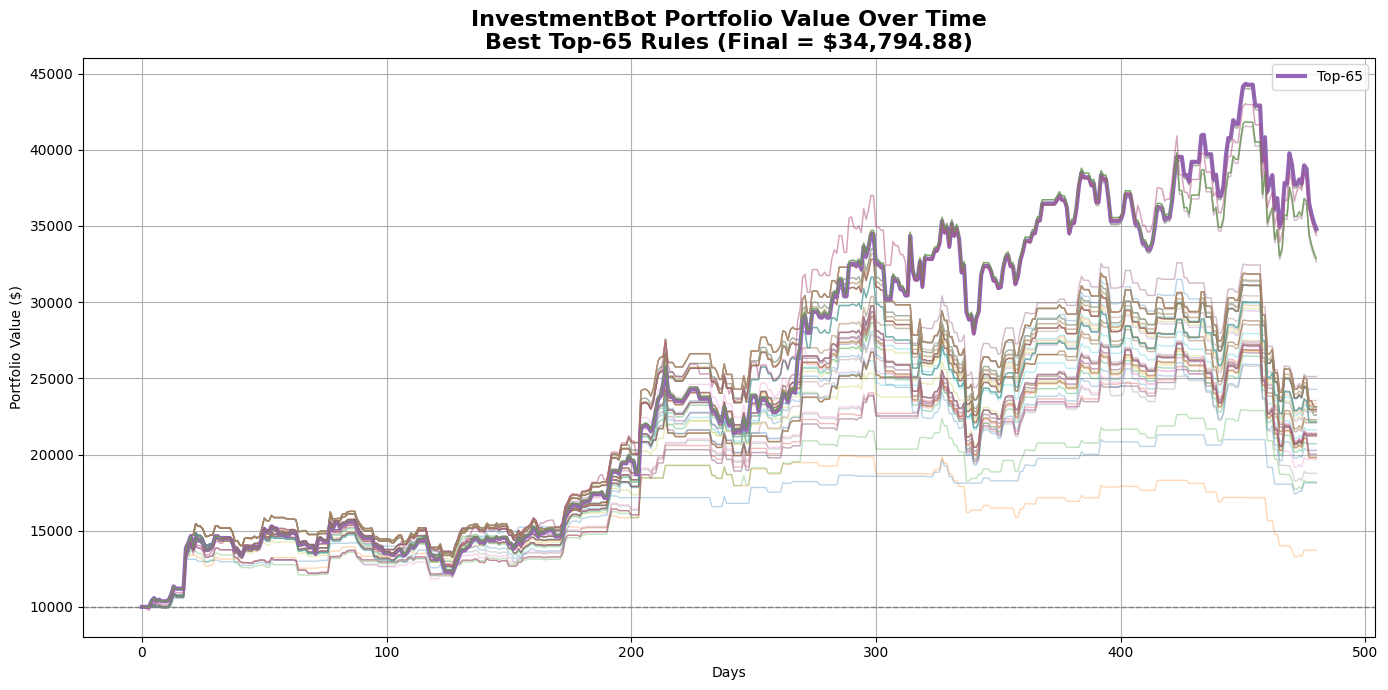

In [6]:
# --------------------------------------------
# 6. Grid Search for Best Rule Count and Plot
# --------------------------------------------
results = {}
for n in range(1, 76):
    bot = InvestmentBot(rules_df, top_n=n)
    perf = bot.run(test_result)
    results[n] = perf

# Identify the best rule count by final portfolio value
final_values = {n: vals[-1] for n, vals in results.items()}
best_n = max(final_values, key=final_values.get)
best_perf = results[best_n]

plt.figure(figsize=(14, 7))

for n, perf in results.items():
    alpha = 0.3 if n != best_n else 1.0
    lw = 1 if n != best_n else 3
    label = f"Top-{n}" if n == best_n else None
    plt.plot(perf, alpha=alpha, linewidth=lw, label=label)

plt.axhline(10000, color='gray', linestyle='--', linewidth=1)
plt.title(f"InvestmentBot Portfolio Value Over Time\nBest Top-{best_n} Rules (Final = ${final_values[best_n]:,.2f})", fontsize=16, weight='bold')
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

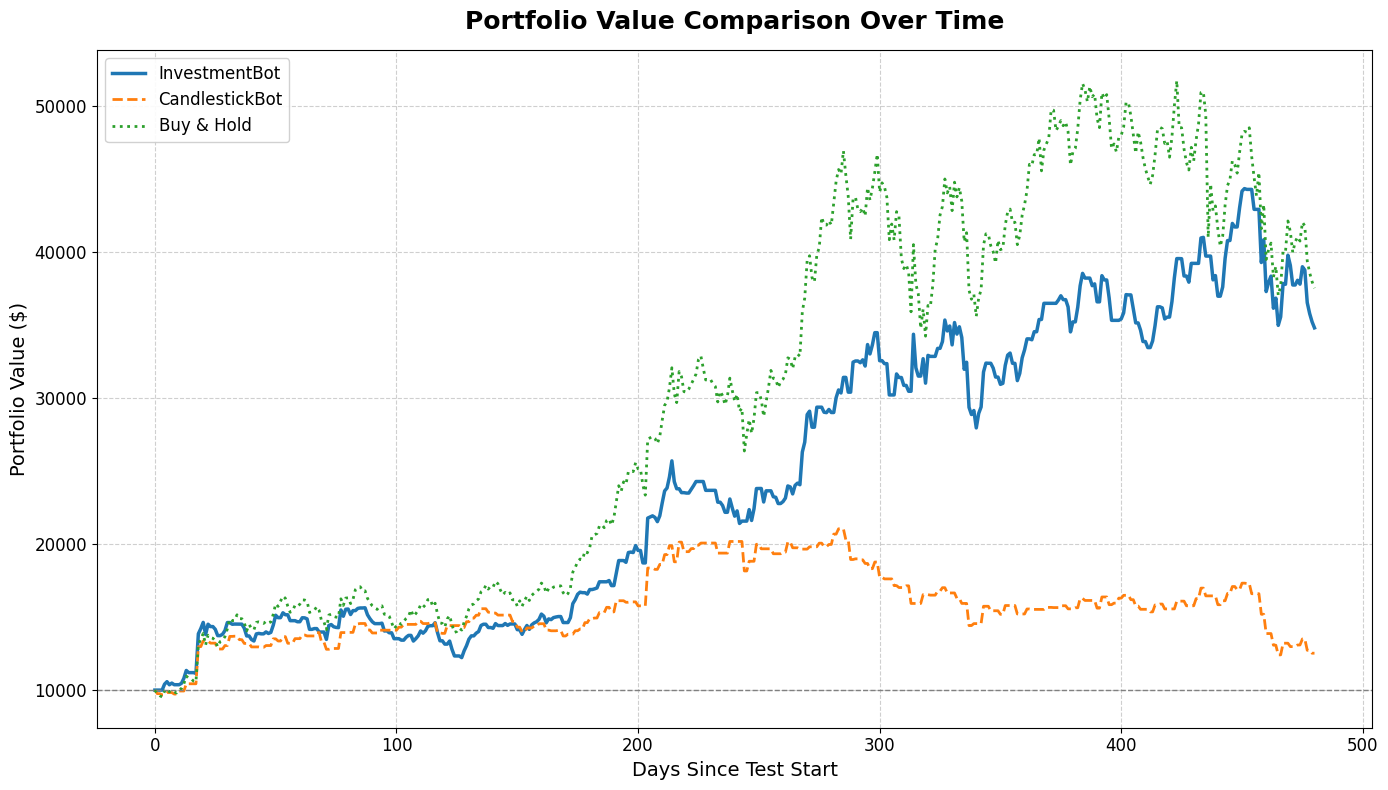

In [7]:
# --------------------------------------------
# 7. Run Bots & Plot
# --------------------------------------------
ibot = InvestmentBot(rules_df, top_n=best_n)
cbot = CandlestickBot([
    "hammer", "doji", "inverted_hammer", "shooting_star",
    "marubozu", "spinning_top", "three_white_soldiers", "dark_cloud_cover", "piercing_line"
])
bhbot = BuyHoldBot()

inv_perf = ibot.run(test_result)
cand_perf = cbot.run(test_result)
buyhold_perf = bhbot.run(test_result)

plt.figure(figsize=(14, 8))
plt.plot(inv_perf, label='InvestmentBot', linewidth=2.5, linestyle='-')
plt.plot(cand_perf, label='CandlestickBot', linewidth=2, linestyle='--')
plt.plot(buyhold_perf, label='Buy & Hold', linewidth=2, linestyle=':')
plt.axhline(y=10000, color='gray', linestyle='--', linewidth=1)

plt.title("Portfolio Value Comparison Over Time", fontsize=18, weight='bold', pad=15)
plt.xlabel("Days Since Test Start", fontsize=14)
plt.ylabel("Portfolio Value ($)", fontsize=14)
plt.legend(fontsize=12, frameon=True, framealpha=0.9, fancybox=True)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

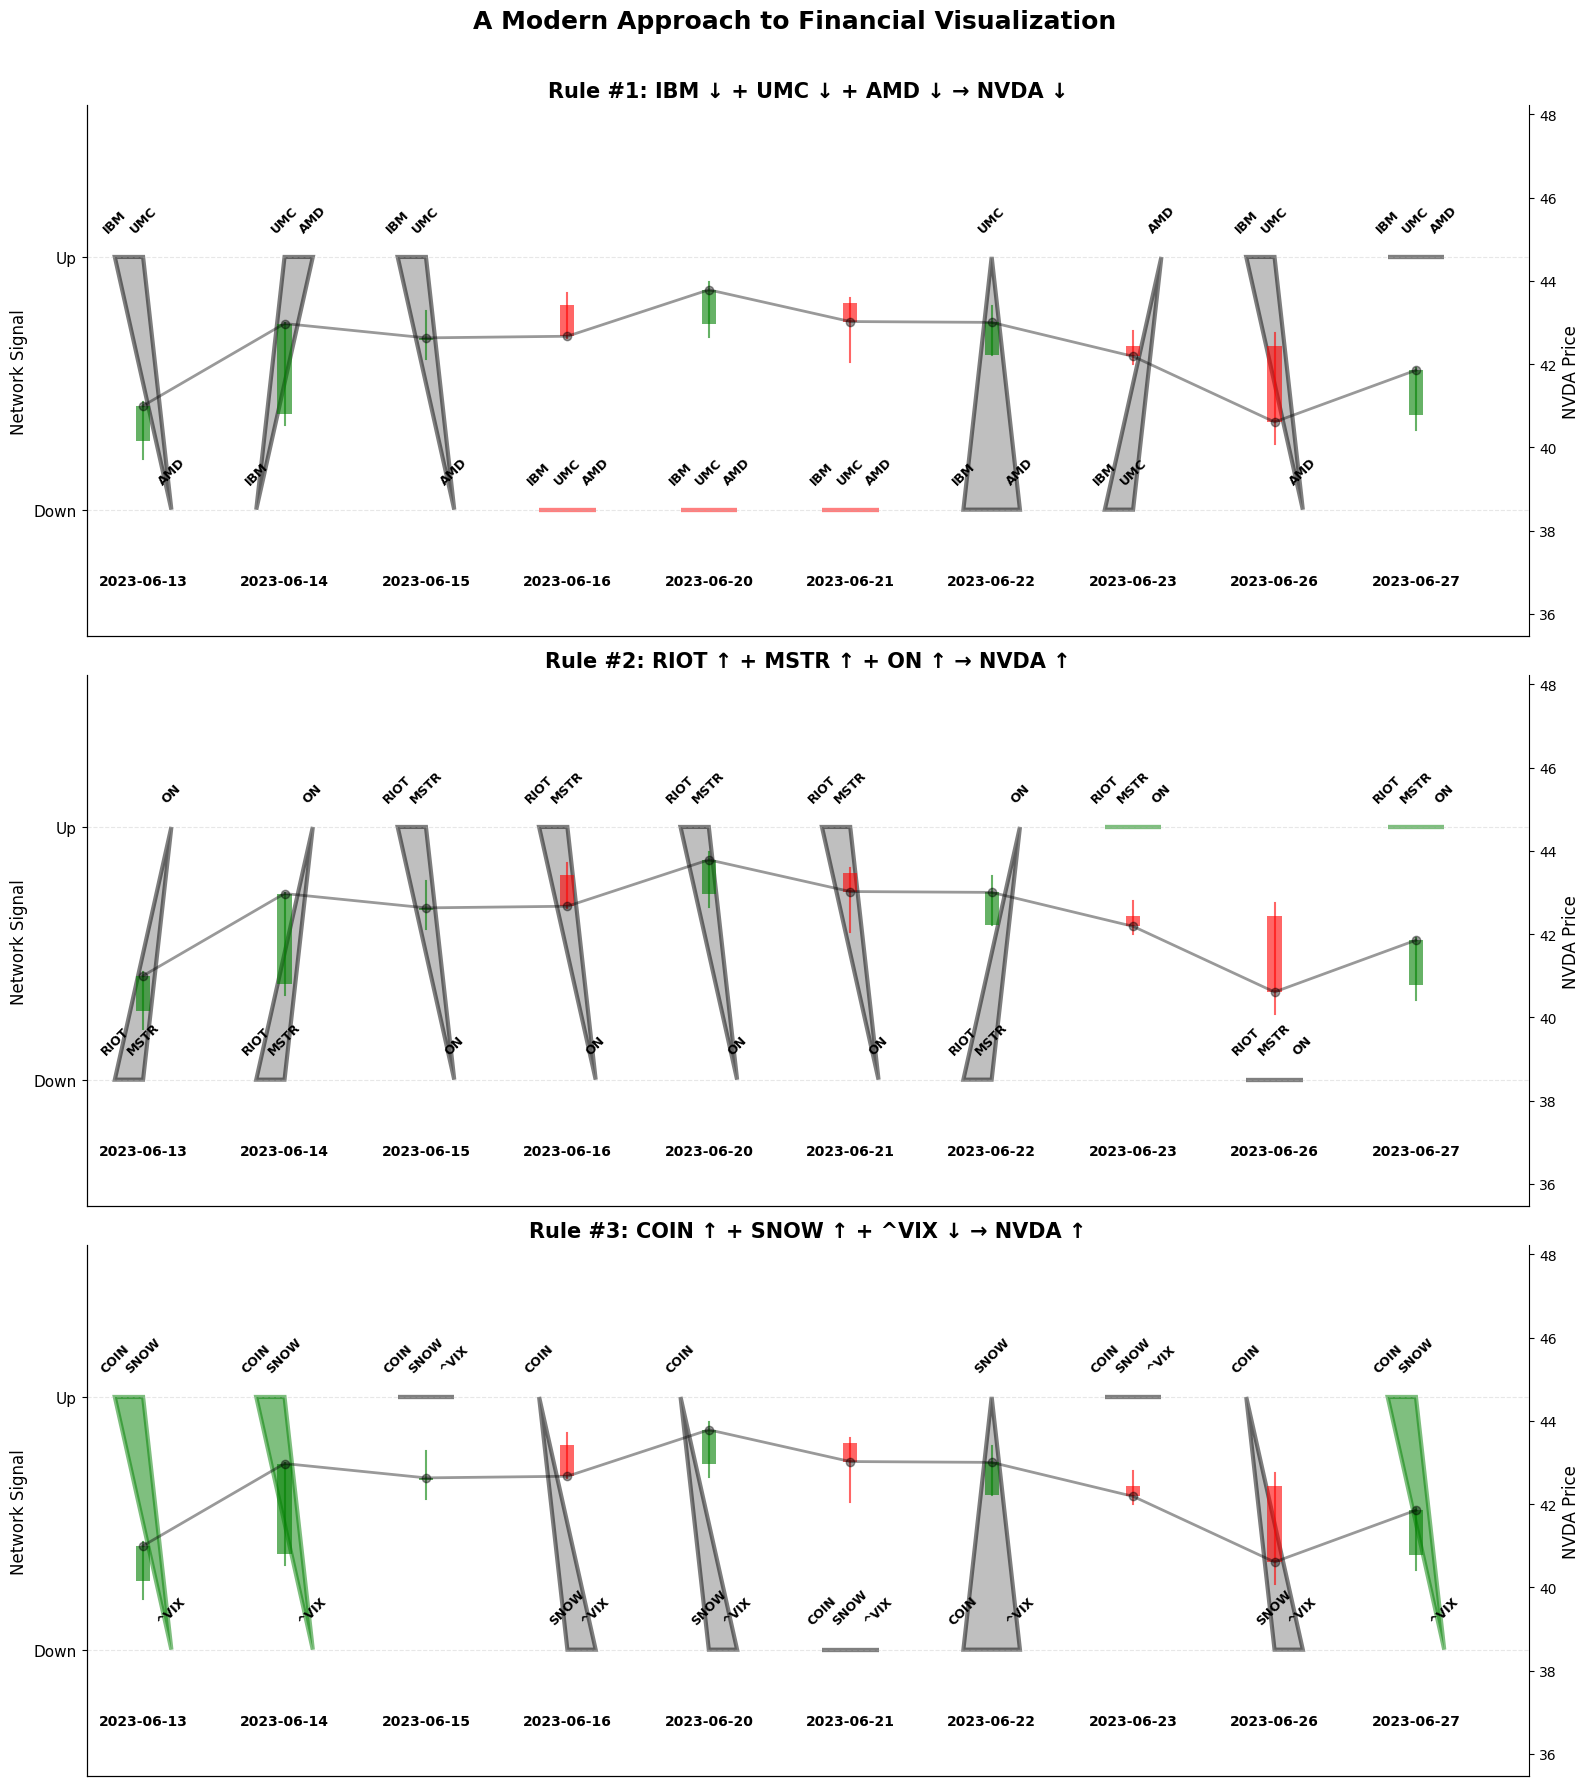

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D

def plot_top_association_rules(rules_df, test_df, test_result, top_n=1):
    test_result.index = pd.to_datetime(test_result.index).normalize()
    test_df["Date"] = pd.to_datetime(test_df["Date"]).dt.normalize()

    dates = test_result.index.unique().sort_values()
    dates = dates[30:40]
    valid_dates = [d for d in dates if d in test_result.index]
    dated_result = test_result.loc[valid_dates]
    num_days = len(valid_dates)
    offset = 5

    fig, axs = plt.subplots(top_n, 1, figsize=(16, 6 * top_n), sharex=True)
    if top_n == 1:
        axs = [axs]  # force list for indexing

    for idx in range(top_n):
        rule = rules_df.iloc[idx]
        antecedents = rule['antecedent']

        assets = [a.replace("_Up", "").replace("_Down", "") for a in antecedents]

        ax = axs[idx]
        ax2 = ax.twinx()

        asset_positions = np.arange(len(assets))

        consequents = rule['consequent']
        if isinstance(consequents, list):
            consequent_col = consequents[0]
        else:
            consequent_col = consequents

        is_buy_rule = "Up" in consequent_col
        is_sell_rule = "Down" in consequent_col

        # Date to X mapping for connecting NVDA line
        date_to_x = {}

        for i, date in enumerate(valid_dates):
            coords = []
            x_coords = []

            # Check if full rule is triggered on this date
            antecedent_triggered = all(dated_result.iloc[i].get(a, 0) == 1 for a in antecedents)
            rule_triggered = antecedent_triggered

            # Final color logic (per date)
            if rule_triggered:
                if is_buy_rule:
                    poly_color = "green"
                    edge_col = "green"
                elif is_sell_rule:
                    poly_color = "red"
                    edge_col = "red"
                else:
                    poly_color = "lightgrey"
                    edge_col = "black"
            else:
                poly_color = "grey"
                edge_col = "black"

            for j, asset in enumerate(assets):
                x = asset_positions[j] + i * offset
                signal_col = antecedents[j]

                row = dated_result.iloc[i]
                signal_value = row.get(signal_col, 0)

                if "_Down" in signal_col:
                    y = 0 if signal_value == 1 else 1
                else:
                    y = 1 if signal_value == 1 else 0
                coords.append((x, y))
                x_coords.append(x)

                # No internal arrow labels — just asset name
                ax.text(x, y + 0.1, asset, ha='center', fontsize=9, rotation=45, fontweight='bold')

            polygon = Polygon(
                coords + [coords[0]],
                closed=True,
                facecolor=poly_color,
                edgecolor=edge_col,
                alpha=0.5,
                linewidth=3
            )
            ax.add_patch(polygon)

            center_x = np.mean(x_coords)
            date_to_x[date.date()] = center_x
            ax.text(center_x, -0.3, str(date.date()), ha='center', fontsize=10, fontweight='bold')

        # Add NVDA candlestick + Close line
        nvda_data = test_df[
            (test_df["Ticker"] == "NVDA") &
            (test_df["Date"].isin(valid_dates))
        ].copy()
        nvda_data["Date"] = pd.to_datetime(nvda_data["Date"]).dt.normalize()
        x_vals = [date_to_x[d.date()] for d in nvda_data["Date"]]
        y_vals = nvda_data["Close"].values

        for _, row in nvda_data.iterrows():
            d = row["Date"].date()
            if d not in date_to_x:
                continue
            x = date_to_x[d]
            o, h, l, c = row["Open"], row["High"], row["Low"], row["Close"]
            color = 'green' if c >= o else 'red'

            # Wick
            ax2.add_line(Line2D([x, x], [l, h], color=color, alpha=0.6, linewidth=1.5))
            # Body
            ax2.add_patch(plt.Rectangle((x - 0.25, min(o, c)), 0.5, abs(c - o),
                                        color=color, alpha=0.6, linewidth=0))

        # Close line
        ax2.plot(x_vals, y_vals, color='black', linewidth=2, linestyle='-', marker='o', alpha=0.4)

        # Axis formatting
        ymin = nvda_data[["Low", "Close"]].min().min()
        ymax = nvda_data[["High", "Close"]].max().max()
        padding = 1 * (ymax - ymin)
        ax2.set_ylim(ymin - padding, ymax + padding)
        ax2.set_ylabel("NVDA Price", fontsize=12)
        ax2.tick_params(axis='y', labelcolor='black')
        ax2.spines['top'].set_visible(False)

        ax.set_xlim(-1, num_days * offset)
        ax.set_ylim(-0.5, 1.6)
        ax.set_xticks([])
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['Down', 'Up'], fontsize=11)
        ax.set_ylabel("Network Signal", fontsize=12)

        # ---- Add arrowed title (outside the plot body) ----
        labeled_antecedents = []
        for a in antecedents:
            base = a.replace("_Up", "").replace("_Down", "")
            arrow = "↑" if "_Up" in a else "↓"
            labeled_antecedents.append(f"{base} {arrow}")
        cons_base = consequent_col.replace("_Up", "").replace("_Down", "")
        cons_arrow = "↑" if "_Up" in consequent_col else "↓"
        labeled_consequent = f"{cons_base} {cons_arrow}"
        ax.set_title(
            f"Rule #{idx+1}: {' + '.join(labeled_antecedents)} → {labeled_consequent}",
            fontsize=15, fontweight='bold'
        )

        ax.grid(True, linestyle='--', alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    fig.suptitle("A Modern Approach to Financial Visualization", fontsize=18, fontweight='bold', y=0.99)
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


plot_top_association_rules(rules_df.sample(100), test_df, test_result, top_n=3)